# Minst

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
import tensorflow.keras.models as models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

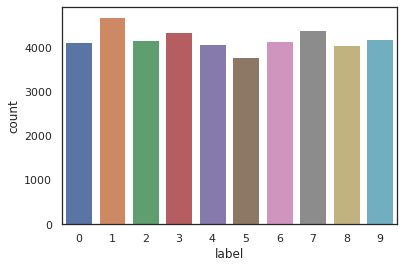

In [2]:
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Y_train = train['label']
X_train = train.drop(labels=['label'], axis=1)
del train

sns.countplot(Y_train)
Y_train.value_counts()

In [3]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [4]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
# Normalize
X_train /= 255.0
test /= 255.0

In [0]:
# Reshape (N, H, W, C)
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [0]:
# Label encoding to one-hot vector
Y_train = to_categorical(Y_train, num_classes=10)

In [0]:
# Split training % validation set
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

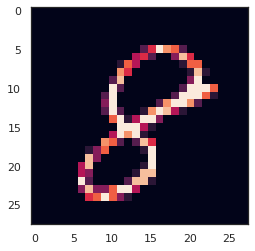

In [9]:
# Show sample
plt.imshow(X_train[0][:,:,0])

## Define Model

In [0]:
# Define the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
        activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
        activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
        activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
        activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [0]:
# Set the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-8, decay=0.0)

In [0]:
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Training & Validation

In [0]:
# Set the learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

# Hyperparams
epochs = 30
batch_size = 86

# Data argumentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

datagen.fit(X_train)

In [14]:
# Fit the model
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
          epochs=epochs, validation_data=(X_val, Y_val), verbose=2,
          steps_per_epoch=X_train.shape[0]//batch_size,
          callbacks=[learning_rate_reduction])

Epoch 1/30
439/439 - 16s - loss: 0.4099 - accuracy: 0.8686 - val_loss: 0.0677 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 2/30
439/439 - 15s - loss: 0.1233 - accuracy: 0.9627 - val_loss: 0.0531 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 3/30
439/439 - 16s - loss: 0.0947 - accuracy: 0.9723 - val_loss: 0.0272 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 4/30
439/439 - 16s - loss: 0.0801 - accuracy: 0.9763 - val_loss: 0.0272 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 5/30
439/439 - 16s - loss: 0.0712 - accuracy: 0.9792 - val_loss: 0.0254 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 6/30
439/439 - 16s - loss: 0.0658 - accuracy: 0.9809 - val_loss: 0.0266 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 7/30

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
439/439 - 16s - loss: 0.0614 - accuracy: 0.9824 - val_loss: 0.0524 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 8/30
439/439 - 16s - loss: 0.0488 - accuracy: 0.9857 - val_loss: 0.0197 - val_accuracy: 0.9948 - lr: 5.0000e-04
Epo

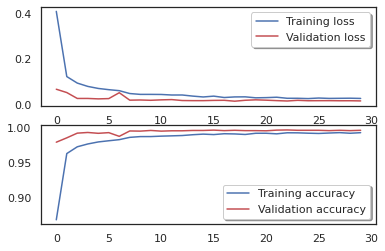

In [15]:
# Training & Validation curve
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=ax[0])
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend(loc='best', shadow=True)

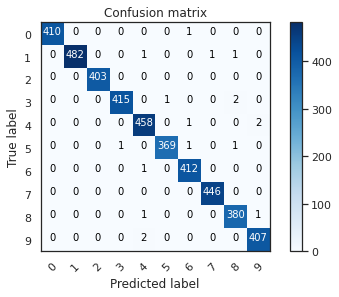

In [16]:
# Confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j], horizontalalignment="center",
          color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(cm, classes=range(10))

In [0]:
# Generate prediction
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

# Generate submission file
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submission.to_csv('submission.csv', index=False)

## Save Model

In [18]:
# Save the model
model.save('tf_model', save_format='tf')

# Load the model
model = models.load_model('tf_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tf_model/assets
